# TP 1

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle, islice
import datetime as datetime
import glob
from matplotlib import pyplot
from IPython.display import Image
import plotly.express as px
import pycountry
#import psutil

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

#import warnings
#warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
eci = pd.read_csv('Entrenamieto_ECI_2020.csv')

# Preprocesamiento y limpieza de datos

Completo los datos faltantes de 'Total_Taxable_Amount' con los de 'Total_Amount'

In [15]:
len(eci['Total_Taxable_Amount'].loc[eci.Total_Taxable_Amount==0.00])

997

In [3]:
eci['Total_Taxable_Amount'].loc[eci.Total_Taxable_Amount==0.00] = eci.loc[eci.Total_Taxable_Amount==0.00]\
                                            .groupby(['Opportunity_Name'])['Total_Amount'].transform('sum')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Vemos que van a quedar pocos valores que tienen 'Total_Taxable_Amount' y 'Total_Amount' en cero. Llegado el caso de estudio, se pueden ignorar

In [9]:
len(eci['Total_Taxable_Amount'].loc[eci.Total_Taxable_Amount==0.00])

97

In [12]:
eci.loc[eci.Total_Taxable_Amount==0.00]['Total_Amount'].value_counts()

0.00    38
Name: Total_Amount, dtype: int64

In [13]:
eci.loc[eci.Total_Taxable_Amount==0.00]['Total_Amount'].isnull().sum()

59

Convierto Total_Amount y Total_Taxable_Amount a una sola moneda

In [6]:
#Para convertir todos los precios de Total_Amount de diferentes monedas a dolar, no voy a usar los precios del
#mercado actual. Voy a utilizar la conversión que se usó en el dataset original en la columna ASP_(converted)

In [4]:
toEUR = eci[eci.ASP_Currency=='EUR'].head(1)[['ASP_(converted)']].iloc[0,0]/eci[eci.ASP_Currency=='EUR'].head(1)[['ASP']].iloc[0,0]
toAUD = eci[eci.ASP_Currency=='AUD'].head(1)[['ASP_(converted)']].iloc[0,0]/eci[eci.ASP_Currency=='AUD'].head(1)[['ASP']].iloc[0,0]
toGBP = eci[eci.ASP_Currency=='GBP'].head(1)[['ASP_(converted)']].iloc[0,0]/eci[eci.ASP_Currency=='GBP'].head(1)[['ASP']].iloc[0,0]
toJPY = eci[['ASP_(converted)']].iloc[12,0]/eci[['ASP']].iloc[12,0]
#En el head(1) de JPY justo habia un nan. Ese numero magico 12 corresponde a la primera fila de moneda JPY con un valor valido

In [8]:
#Lo siguiente es para comprobar que funciona bien

In [9]:
eci['ASP_(convertido)']=0.0
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='EUR'] = eci['ASP'].apply(lambda x: x*toEUR)
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='JPY'] = eci['ASP'].apply(lambda x: x*toJPY)
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='AUD'] = eci['ASP'].apply(lambda x: x*toAUD)
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='GBP'] = eci['ASP'].apply(lambda x: x*toGBP)
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='USD'] = eci['ASP'].apply(lambda x: x)

In [10]:
eciAux = eci.dropna(subset=['ASP_(converted)'])

In [11]:
print("Coinciden todos en el subset: ", all(abs(eciAux['ASP_(converted)']-eciAux['ASP_(convertido)']) < 0.01))

Coinciden todos en el subset:  True


In [12]:
del eciAux
eci.drop(columns='ASP_(convertido)',inplace=True)

In [5]:
#Ahora si hago la conversion
eci['Total_Amount_(converted)']=0.0
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='EUR'] = eci['Total_Amount'].apply(lambda x: x*toEUR)
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='JPY'] = eci['Total_Amount'].apply(lambda x: x*toJPY)
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='AUD'] = eci['Total_Amount'].apply(lambda x: x*toAUD)
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='GBP'] = eci['Total_Amount'].apply(lambda x: x*toGBP)
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='USD'] = eci['Total_Amount'].apply(lambda x: x)

eci['Total_Taxable_Amount_(converted)']=0.0
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='EUR'] = eci['Total_Taxable_Amount'].apply(lambda x: x*toEUR)
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='JPY'] = eci['Total_Taxable_Amount'].apply(lambda x: x*toJPY)
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='AUD'] = eci['Total_Taxable_Amount'].apply(lambda x: x*toAUD)
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='GBP'] = eci['Total_Taxable_Amount'].apply(lambda x: x*toGBP)
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='USD'] = eci['Total_Taxable_Amount'].apply(lambda x: x)

In [6]:
#Nuevas columnas que voy a usar después
eci['Cantidad_de_Productos_por_Oportunidad'] = eci.groupby('Opportunity_ID')['ID'].transform('count')
eci['TRF_totales'] = eci.groupby('Opportunity_ID')['TRF'].transform('sum')
eci['TRF_promedioDeLaOportunidad'] = eci.groupby('Opportunity_ID')['TRF'].transform('mean')

In [13]:
#Columna inservible
eci['Actual_Delivery_Date'].value_counts()

NaT    16947
Name: Actual_Delivery_Date, dtype: int64

In [135]:
#Columna inservible
eci['Last_Activity'].value_counts()

NaT    16947
Name: Last_Activity, dtype: int64

In [23]:
#Columna inservible (creo)
eci['Submitted_for_Approval'].value_counts()

0    16947
Name: Submitted_for_Approval, dtype: int64

In [57]:
#Columna inservible (creo)
eci['Prod_Category_A'].value_counts()

Prod_Category_A_None    16947
Name: Prod_Category_A, dtype: int64

In [156]:
#Todo es en dolares
eci['ASP_(converted)_Currency'].value_counts()

USD    16947
Name: ASP_(converted)_Currency, dtype: int64

In [136]:
#Supongo que todas estas columnas se pueden eliminar

COLUMNAS CON MUCHISIMOS VALORES NULOS (VER QUE HACER): Brand, Product_Type, Size, Product_Category_B, Price, Currency

# Preguntas

In [7]:
eciOp = eci.drop_duplicates('Opportunity_ID')

In [9]:
stage = eciOp['Stage'].value_counts().to_frame().reset_index()\
                      .rename(columns={'index':'Stage','Stage':'cantidad'})
stage

,Stage,cantidad
0,Closed Won,5072
1,Closed Lost,4719
2,Proposal,30
3,Negotiation,11
4,Qualification,9


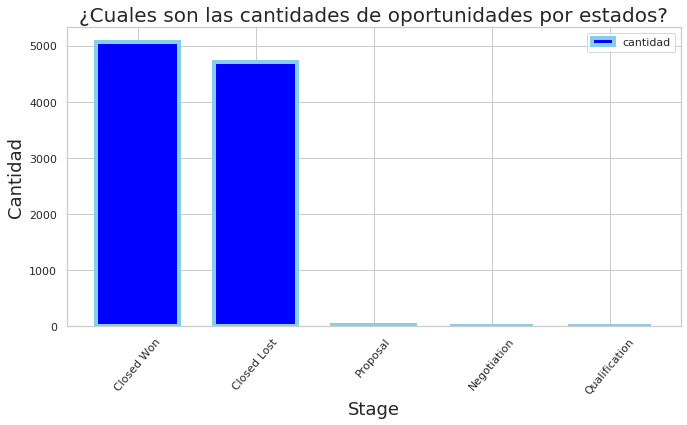

In [10]:
stage.plot(kind='bar', x='Stage', y='cantidad',\
                 width=0.7, figsize=(11,5.5), color='blue',\
                 edgecolor="skyblue", linewidth=4, rot=50)
g=plt.gca()
g.set_title("¿Cuales son las cantidades de oportunidades por estados?",\
            fontsize=20);
g.set_xlabel("Stage", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

In [46]:
region = eciOp['Region'].value_counts().to_frame().reset_index()\
                        .rename(columns={'index':'Region','Region':'cantidad'})
region

,Region,cantidad
0,EMEA,3241
1,Americas,2459
2,APAC,2086
3,Japan,1906
4,Middle East,149


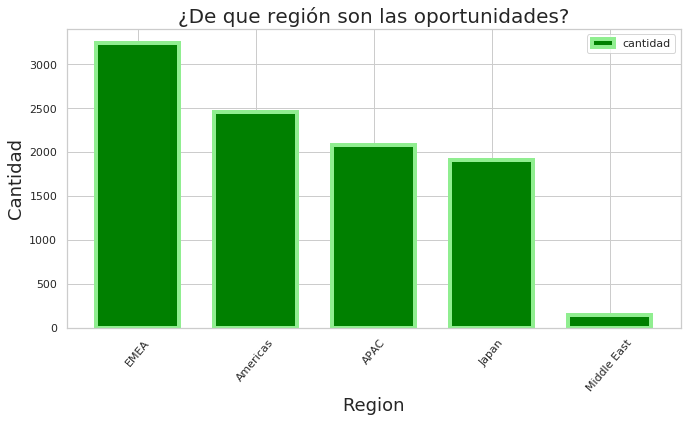

In [7]:
region.plot(kind='bar', x='Region', y='cantidad',\
                 width=0.7, figsize=(11,5.5), color='green',\
                 edgecolor="lightgreen", linewidth=4, rot=50)
g=plt.gca()
g.set_title("¿De que región son las oportunidades?",\
            fontsize=20);
g.set_xlabel("Region", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

In [18]:
territory = eciOp['Territory'].value_counts().to_frame().reset_index()\
                              .rename(columns={'index':'Territorio','Territory':'Cantidad'})
territory = territory[territory['Territorio']!='None']
territory

,Territorio,Cantidad
1,Germany,1080
2,NW America,878
3,India,680
4,Japan,607
5,Australia,579
...,...,...
71,Czech Republic,1
72,Croatia,1
73,Slovenia,1
74,Burma,1


In [19]:
def cambiar_nombre(nombre):
    switcher = {
        'China (PRC)': 'China',
        'South Korea': 'Korea, Republic of',
        'KSA': 'Saudi Arabia',
        'Vietnam': 'Viet Nam',
        'Taiwan': 'Taiwan, Province of China',
        'UAE (Dubai)': 'United Arab Emirates',
        'NW America': 'United States',
        'Central US': 'United States',
        'SE America': 'United States',
        'NE America': 'United States',
        'SW America': 'United States',
        'Macedonia': 'North Macedonia',
        'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
        'Czech Republic': 'Czechia',
        'Burma': 'Myanmar',
        'Palestine': 'Palestine, State of',
        'Macedonia, the former Yugoslav Republic of': 'North Macedonia'
    }
    return switcher.get(nombre,nombre)

In [20]:
territory['Territorio'] = territory['Territorio'].apply(lambda x: cambiar_nombre(x))

In [21]:
def get_alpha_3(location):
    try:
        return pycountry.countries.get(name=location).alpha_3
    except:
        return 'Desconocido'

In [22]:
territory['Code'] = territory['Territorio'].apply(lambda x: get_alpha_3(x))

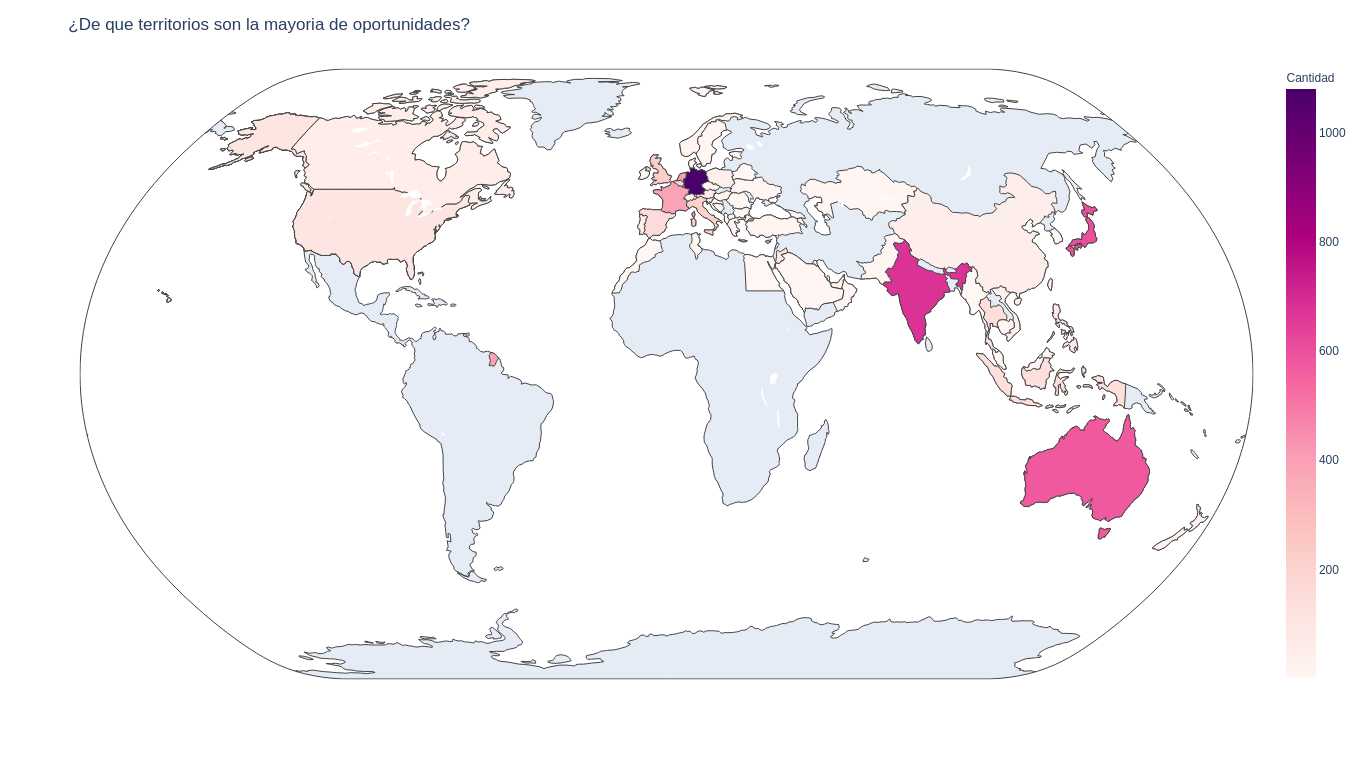

In [23]:
fig = px.choropleth(territory,locations='Code',color='Cantidad',\
                    color_continuous_scale=px.colors.sequential.RdPu,hover_name='Territorio',)
fig.update_layout(
    title_text = '¿De que territorios son la mayoria de oportunidades?'
)
fig.update_geos(projection_type="natural earth")
#fig.show()
fig.write_image("territorio.png",width=1366,height= 768)
Image("territorio.png")

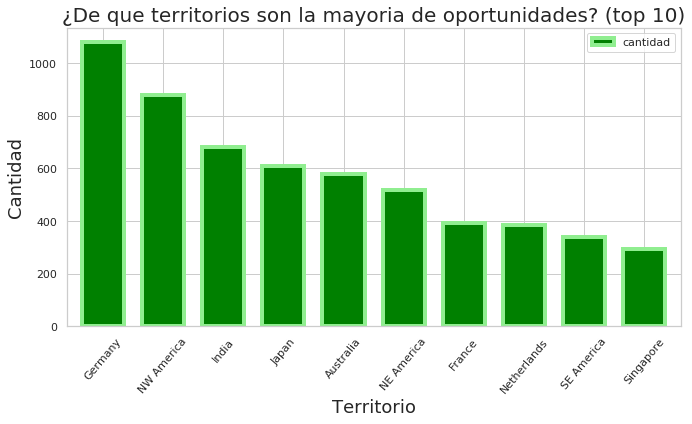

In [9]:
territory.plot(kind='bar', x='Territorio', y='cantidad',\
                 width=0.7, figsize=(11,5.5), color='green',\
                 edgecolor="lightgreen", linewidth=4, rot=50)
g=plt.gca()
g.set_title("¿De que territorios son la mayoria de oportunidades? (top 10)",\
            fontsize=20);
g.set_xlabel("Territorio", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

In [24]:
billingCountry = eciOp['Billing_Country'].value_counts().to_frame().reset_index()\
                                         .rename(columns={'index':'Pais','Billing_Country':'Cantidad'})
billingCountry 

,Pais,Cantidad
0,United States,2350
1,Japan,1899
2,Germany,1308
3,India,560
4,Australia,559
...,...,...
75,Dominican Republic,1
76,Slovakia,1
77,Malaysia,1
78,Belize,1


In [25]:
billingCountry ['Pais'] = billingCountry ['Pais'].apply(lambda x: cambiar_nombre(x))
billingCountry['Code'] = billingCountry['Pais'].apply(lambda x: get_alpha_3(x))

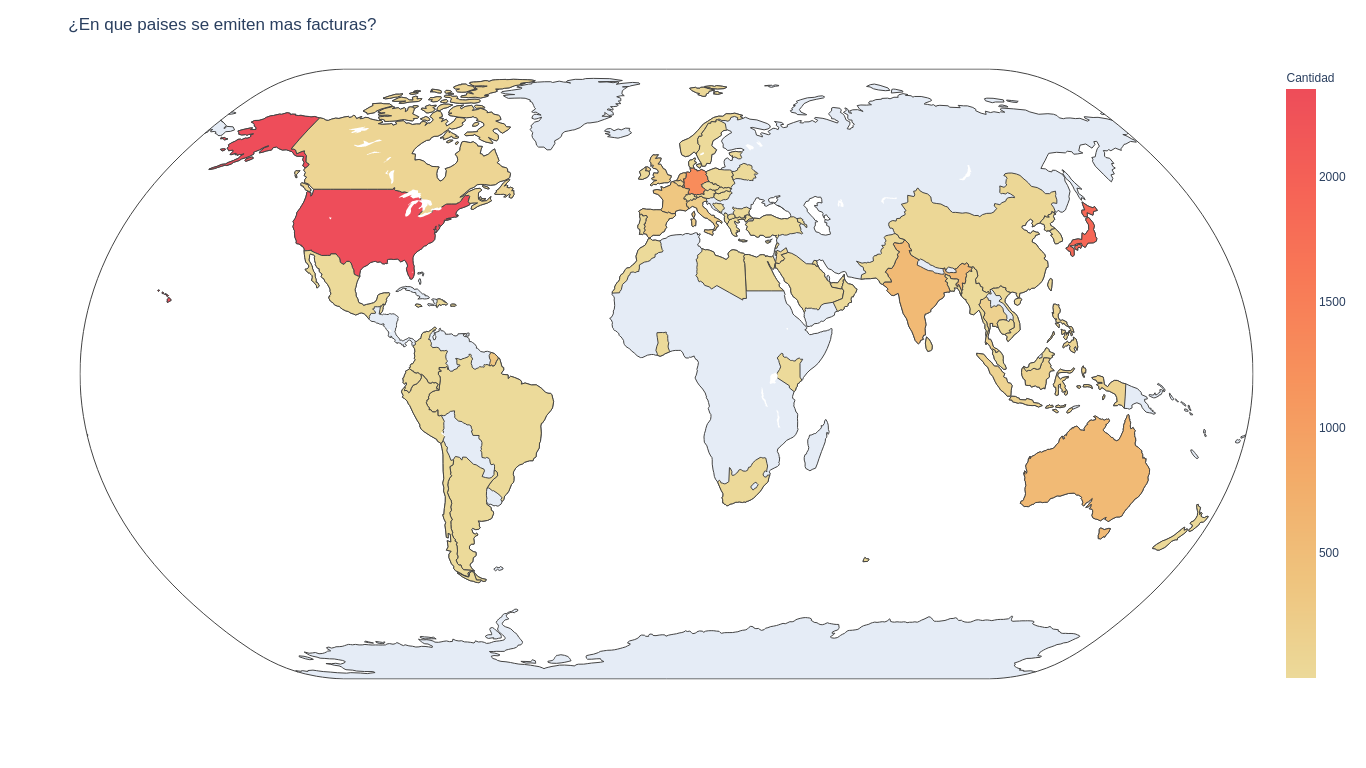

In [26]:
fig = px.choropleth(billingCountry,locations='Code',color='Cantidad',\
                    color_continuous_scale=px.colors.sequential.Oryel,hover_name='Pais',)
fig.update_layout(
    title_text = '¿En que paises se emiten mas facturas?'
)
fig.update_geos(projection_type="natural earth")
#fig.show()
fig.write_image("billing.png",width=1366,height= 768)
Image("billing.png")

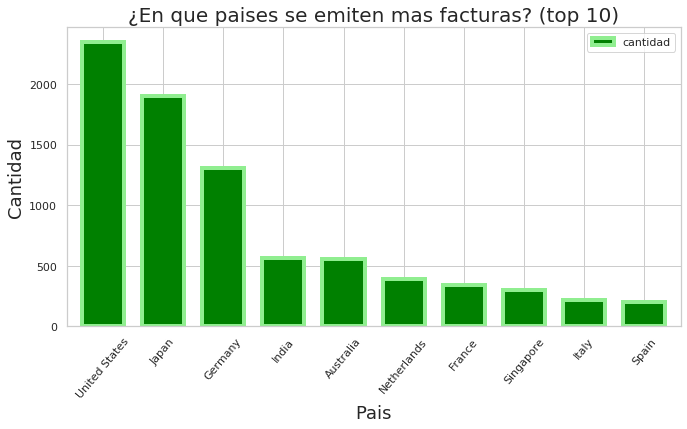

In [36]:
billingCountry.head(10).plot(kind='bar', x='Pais', y='cantidad',\
                 width=0.7, figsize=(11,5.5), color='green',\
                 edgecolor="lightgreen", linewidth=4, rot=50)
g=plt.gca()
g.set_title("¿En que paises se emiten mas facturas? (top 10)",\
            fontsize=20);
g.set_xlabel("Pais", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

In [7]:
eciOp['Account_Created_Date'] = pd.to_datetime(eciOp['Account_Created_Date'])
eciOp['Account_Created_Year'] = eciOp['Account_Created_Date'].dt.year
accountCreatedYear = eciOp.groupby('Account_Created_Year').agg({'ID':'count'}).reset_index().rename(columns={'ID':'cantidad','Account_Created_Year':'Año'})
accountCreatedYear

/home/german/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/german/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Año,cantidad
0,2013,2835
1,2014,885
2,2015,1898
3,2016,2137
4,2017,1526
5,2018,560


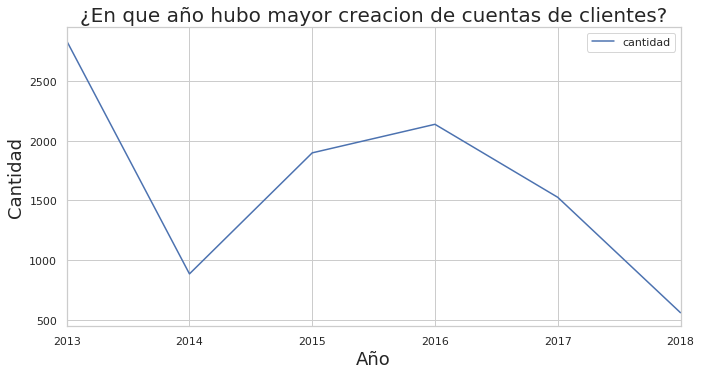

In [8]:
accountCreatedYear.plot(kind='line', x='Año', y='cantidad',figsize=(11,5.5))
g=plt.gca()
g.set_title("¿En que año hubo mayor creacion de cuentas de clientes?",\
            fontsize=20);
g.set_xlabel("Año", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

In [9]:
eci['Opportunity_Created_Date'] = pd.to_datetime(eci['Opportunity_Created_Date'])
eci['Opportunity_Created_Year'] = eci['Opportunity_Created_Date'].dt.year
opportunityCreatedYear = eci.groupby('Opportunity_Created_Year').agg({'ID':'count'}).reset_index().rename(columns={'ID':'cantidad','Opportunity_Created_Year':'Año'})
opportunityCreatedYear

,Año,cantidad
0,2013,1
1,2014,40
2,2015,1012
3,2016,4355
4,2017,6921
5,2018,4618


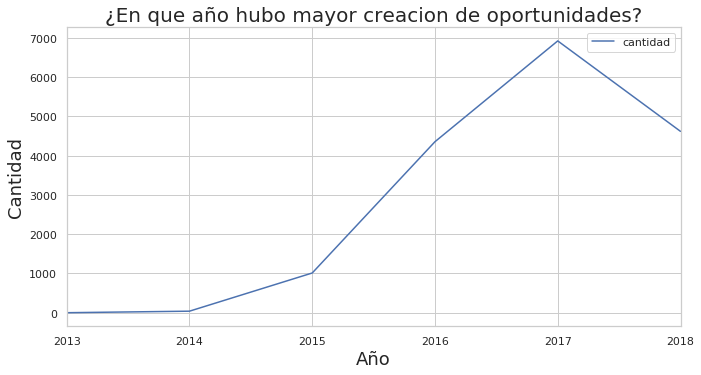

In [10]:
opportunityCreatedYear.plot(kind='line', x='Año', y='cantidad',figsize=(11,5.5))
g=plt.gca()
g.set_title("¿En que año hubo mayor creacion de oportunidades?",\
            fontsize=20);
g.set_xlabel("Año", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

Text(0.5, 0, 'Estado')

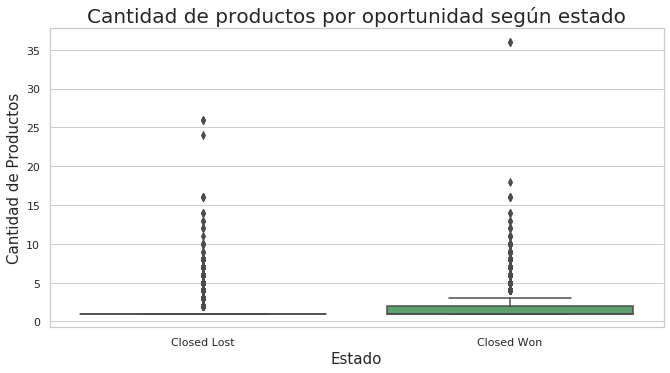

In [29]:
plt.figure(figsize=(11,5.5))

visua=sns.boxplot(x="Stage", y="Cantidad_de_Productos_por_Oportunidad", palette=["m", "g"], data=eciOp[(eciOp.Stage=='Closed Lost')|(eciOp.Stage=='Closed Won')])
visua.set_title("Cantidad de productos por oportunidad según estado", fontsize=20)
visua.set_ylabel("Cantidad de Productos" , fontsize=15)
visua.set_xlabel("Estado", fontsize=15)

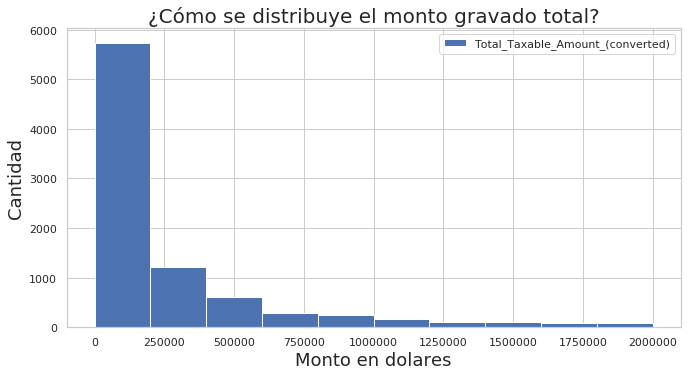

In [34]:
#Con el limite que puse en el rango se ve mejor, aunque no estoy teniendo en cuenta los valores mas grandes
#que se hacen cada vez mas chicos
eciOp[['Total_Taxable_Amount_(converted)']].plot(kind='hist',figsize=(11,5.5),range=[0,2000000])
g=plt.gca()
g.set_title("¿Cómo se distribuye el monto gravado total?",fontsize=20);
g.set_xlabel("Monto en dolares", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

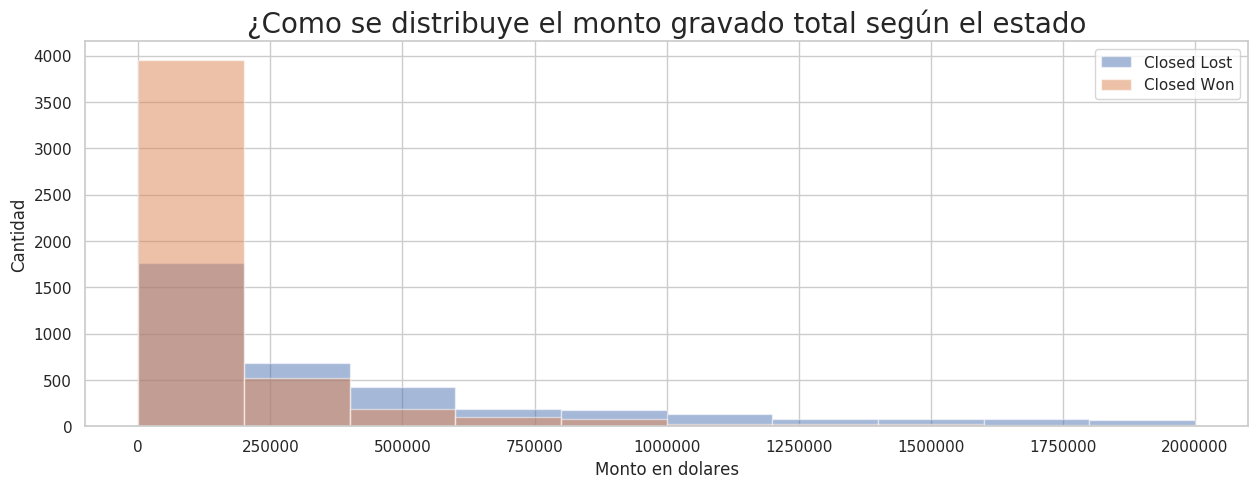

In [49]:
pyplot.hist(eciOp[eciOp.Stage=='Closed Lost']['Total_Taxable_Amount_(converted)'], alpha=0.5, label='Closed Lost',range=[0,2000000])
pyplot.hist(eciOp[eciOp.Stage=='Closed Won']['Total_Taxable_Amount_(converted)'], alpha=0.5, label='Closed Won',range=[0,2000000])
pyplot.title("¿Como se distribuye el monto gravado total según el estado", fontsize=20)
pyplot.ylabel('Cantidad')
pyplot.xlabel('Monto en dolares')
pyplot.legend()

In [54]:
necesitaAprobacion = eciOp['Pricing, Delivery_Terms_Quote_Appr'].value_counts()[1]
obtuvoAprobacion = eciOp['Pricing, Delivery_Terms_Approved'].value_counts()[1]

Text(0, 0.5, 'Cantidad de oportunidades')

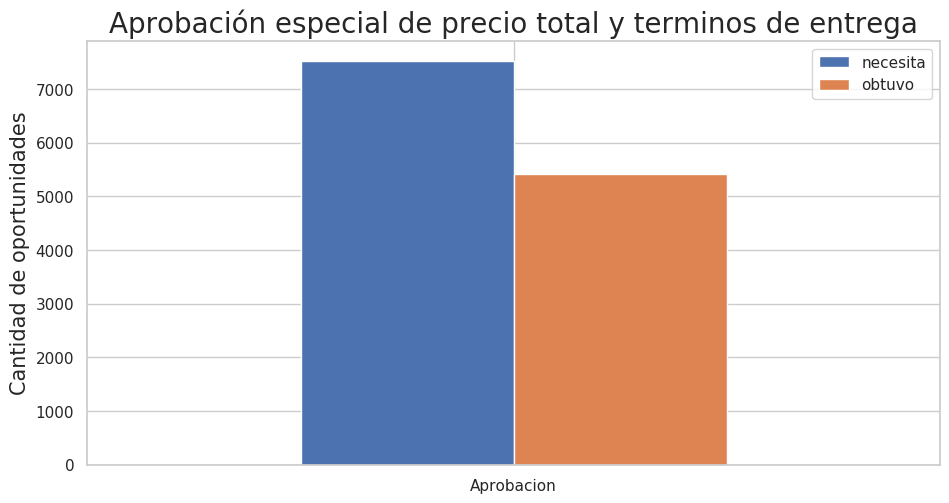

In [55]:
index = ['Aprobacion']
df = pd.DataFrame({'necesita': necesitaAprobacion,'obtuvo': obtuvoAprobacion}, index=index)
ax = df.plot.bar(rot=0,figsize=(11,5.5))
ax.set_title("Aprobación especial de precio total y terminos de entrega", fontsize=20)
ax.set_ylabel("Cantidad de oportunidades" , fontsize=15)

In [56]:
necesitaCodigo = eciOp['Bureaucratic_Code_0_Approval'].value_counts()[1]
obtuvoCodigo = eciOp['Bureaucratic_Code_0_Approved'].value_counts()[1]

Text(0, 0.5, 'Cantidad de oportunidades')

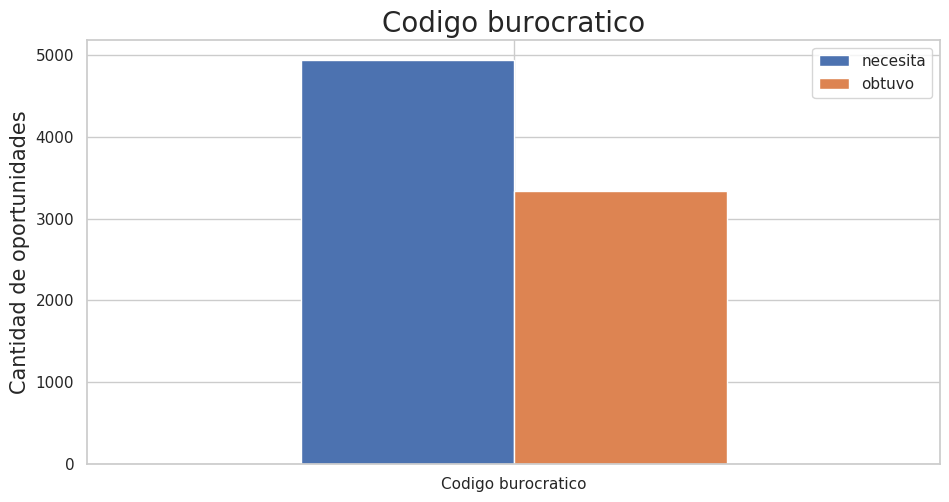

In [57]:
index = ['Codigo burocratico']
df = pd.DataFrame({'necesita': necesitaCodigo,'obtuvo': obtuvoCodigo}, index=index)
ax = df.plot.bar(rot=0,figsize=(11,5.5))
ax.set_title("Codigo burocratico", fontsize=20)
ax.set_ylabel("Cantidad de oportunidades" , fontsize=15)

In [9]:
eciWon = eciOp[(eciOp.Stage=='Closed Won')|(eciOp.Stage=='Closed Lost')]

In [10]:
eciWon['ganada'] = eciWon['Stage'].apply(lambda x: 1 if x=='Closed Won' else 0)

/home/german/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
regionGroup = eciWon.groupby(['Region']).agg({'ganada':['sum','count']}).reset_index()
regionGroup.columns = ['Region','cantidad de won','total']
regionGroup

,Region,cantidad de won,total
0,APAC,1155,2079
1,Americas,1094,2452
2,EMEA,1500,3237
3,Japan,1290,1885
4,Middle East,33,138


In [12]:
regionGroup['porcentaje de oportunidades ganadas'] = regionGroup['cantidad de won']/regionGroup['total']*100
regionGroup.sort_values('porcentaje de oportunidades ganadas',ascending=False,inplace=True)

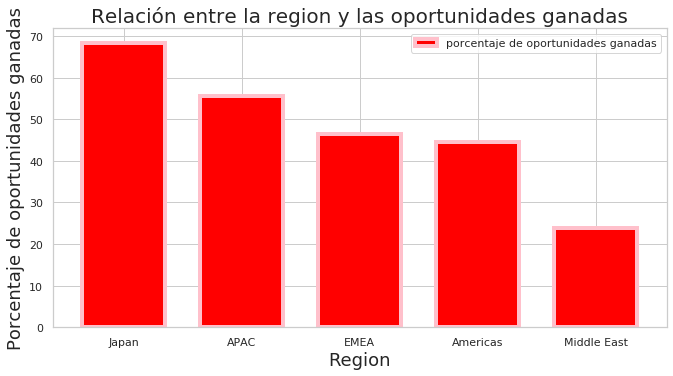

In [13]:
regionGroup.plot(kind='bar', x='Region', y='porcentaje de oportunidades ganadas',\
                 width=0.7, figsize=(11,5.5), color='red',\
                 edgecolor="pink", linewidth=4,rot=0)
g=plt.gca()
g.set_title("Relación entre la region y las oportunidades ganadas",\
            fontsize=20);
g.set_xlabel("Region", fontsize=18);
g.set_ylabel("Porcentaje de oportunidades ganadas", fontsize=18);

In [21]:
territoryGroup = eciWon.groupby(['Territory']).agg({'ganada':['sum','count']}).reset_index()
territoryGroup.columns = ['Territory','cantidad de won','total']
territoryGroup

,Territory,cantidad de won,total
0,Albania,0,2
1,Armenia,0,1
2,Australia,383,577
3,Austria,58,72
4,Belarus,0,3
...,...,...,...
70,UAE (Dubai),2,28
71,UAE (Others),2,2
72,Ukraine,0,4
73,United Kingdom,89,228


In [22]:
#Sacamos los territorios que aparcen muy pocas veces para no caer en "la ecuacion mas peligrosa de la historia"
territoryGroup = territoryGroup[territoryGroup['total']>10]

In [23]:
territoryGroup['porcentaje de oportunidades ganadas'] = territoryGroup['cantidad de won']/territoryGroup['total']*100
territoryGroup.sort_values('porcentaje de oportunidades ganadas',ascending=False,inplace=True)

/home/german/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/german/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


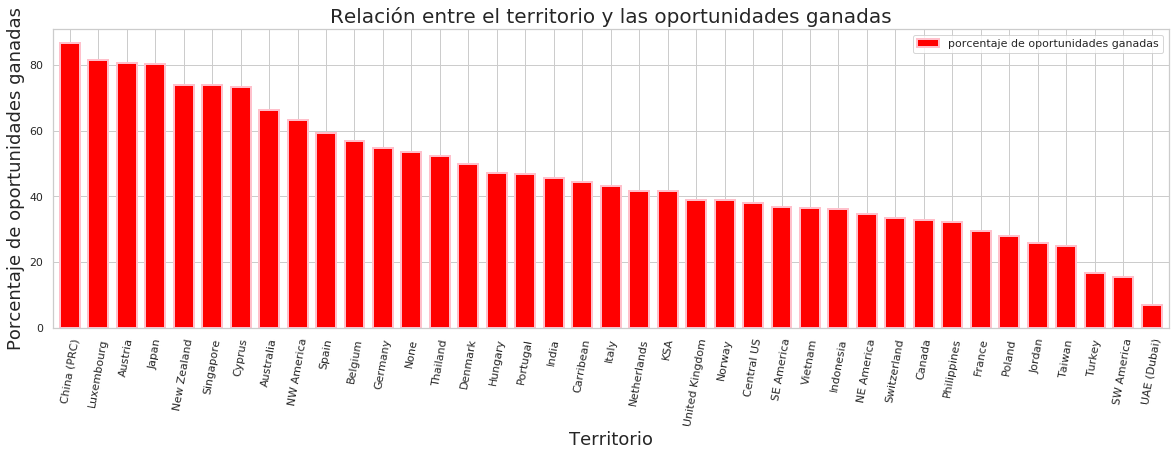

In [24]:
territoryGroup.plot(kind='bar', x='Territory', y='porcentaje de oportunidades ganadas',\
                 width=0.7, figsize=(20,5.5), color='red',\
                 edgecolor="pink", linewidth=2,rot=80)
g=plt.gca()
g.set_title("Relación entre el territorio y las oportunidades ganadas",\
            fontsize=20);
g.set_xlabel("Territorio", fontsize=18);
g.set_ylabel("Porcentaje de oportunidades ganadas", fontsize=18);

In [25]:
billingCountryGroup = eciWon.groupby(['Billing_Country']).agg({'ganada':['sum','count']}).reset_index()
billingCountryGroup.columns = ['Billing_Country','cantidad de won','total']
billingCountryGroup

,Billing_Country,cantidad de won,total
0,Albania,0,2
1,Argentina,0,1
2,Armenia,0,1
3,Australia,382,558
4,Austria,56,71
...,...,...,...
74,Turkey,3,9
75,United Arab Emirates,5,38
76,United Kingdom,88,197
77,United States,1059,2343


In [26]:
billingCountryGroup = billingCountryGroup[billingCountryGroup['total']>10]

In [27]:
billingCountryGroup['porcentaje de oportunidades ganadas'] = billingCountryGroup['cantidad de won']/billingCountryGroup['total']*100
billingCountryGroup.sort_values('porcentaje de oportunidades ganadas',ascending=False,inplace=True)

/home/german/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/german/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
#Este grafico de abajo no se si tiene mucho sentido. Hice lo mismo que antes solo que en lugar de region o
#territorio usé los paises que figuran en emision de facturas. Pero no se bien que titulo ponerle, puede que sea
#un indicio de que no tiene sentido. Si no lo tiene, se saca

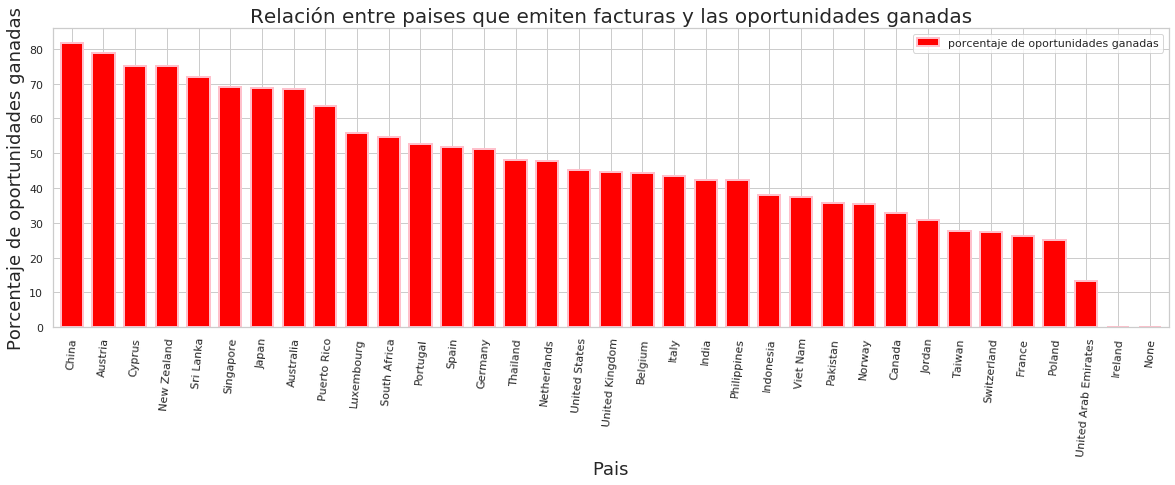

In [29]:
billingCountryGroup.plot(kind='bar', x='Billing_Country', y='porcentaje de oportunidades ganadas',\
                 width=0.7, figsize=(20,5.5), color='red',\
                 edgecolor="pink", linewidth=2, rot=85)
g=plt.gca()
g.set_title("Relación entre paises que emiten facturas y las oportunidades ganadas",\
            fontsize=20);
g.set_xlabel("Pais", fontsize=18);
g.set_ylabel("Porcentaje de oportunidades ganadas", fontsize=18);

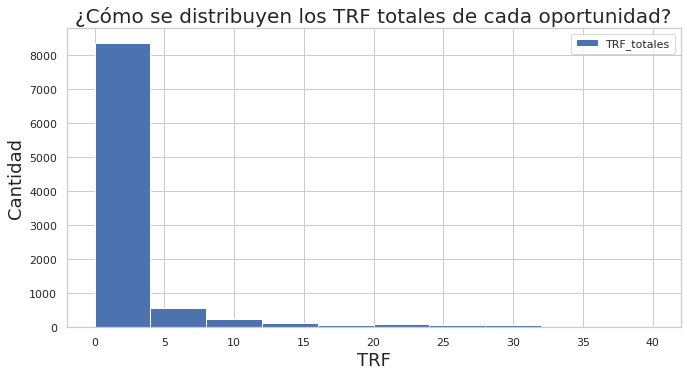

In [44]:
#Con el limite que puse en el rango se ve mejor, aunque no estoy teniendo en cuenta los valores mas grandes
#que se hacen cada vez mas chicos
eciOp[['TRF_totales']].plot(kind='hist',figsize=(11,5.5),range=[0,40])
g=plt.gca()
g.set_title("¿Cómo se distribuyen los TRF totales de cada oportunidad?",fontsize=20);
g.set_xlabel("TRF", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

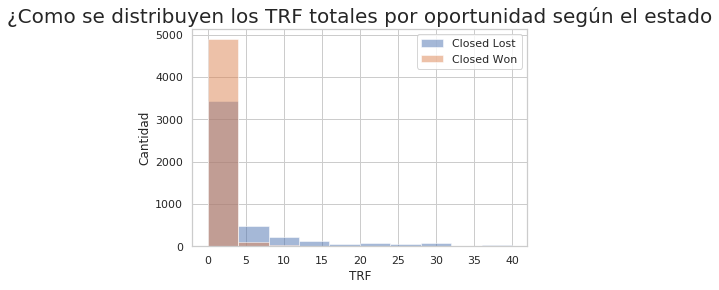

In [45]:
pyplot.hist(eciOp[eciOp.Stage=='Closed Lost']['TRF_totales'], alpha=0.5, label='Closed Lost',range=[0,40])
pyplot.hist(eciOp[eciOp.Stage=='Closed Won']['TRF_totales'], alpha=0.5, label='Closed Won',range=[0,40])
pyplot.title("¿Como se distribuyen los TRF totales por oportunidad según el estado", fontsize=20)
pyplot.ylabel('Cantidad')
pyplot.xlabel('TRF')
pyplot.legend()

In [47]:
TRF_promedio = eciOp.groupby('Stage').agg({'TRF_promedioDeLaOportunidad':'mean'}).reset_index()
TRF_promedio

,Stage,TRF_promedioDeLaOportunidad
0,Closed Lost,5.79
1,Closed Won,0.35
2,Negotiation,1.14
3,Proposal,4.68
4,Qualification,3.00


In [50]:
#Me sorprende que haya tanta diferencia entre el TRF promedio de perdidas y ganadas. Si no me equivoqué, es una
#gran conclusión. Pero es tan grande la diferencia que me da miedo que le pifie a algun calculo o hice algo que
#no tiene sentido. SI PUEDEN MIREN SI HICE LAS COSAS BIEN.

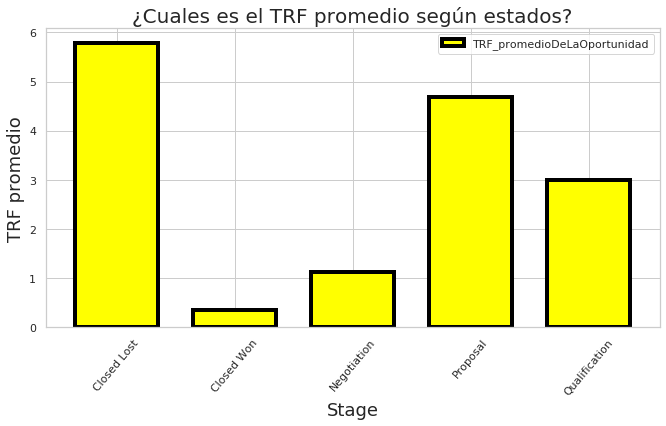

In [49]:
TRF_promedio.plot(kind='bar', x='Stage', y='TRF_promedioDeLaOportunidad',\
                 width=0.7, figsize=(11,5.5), color='yellow',\
                 edgecolor="black", linewidth=4, rot=50)
g=plt.gca()
g.set_title("¿Cuales es el TRF promedio según estados?",\
            fontsize=20);
g.set_xlabel("Stage", fontsize=18);
g.set_ylabel("TRF promedio", fontsize=18);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


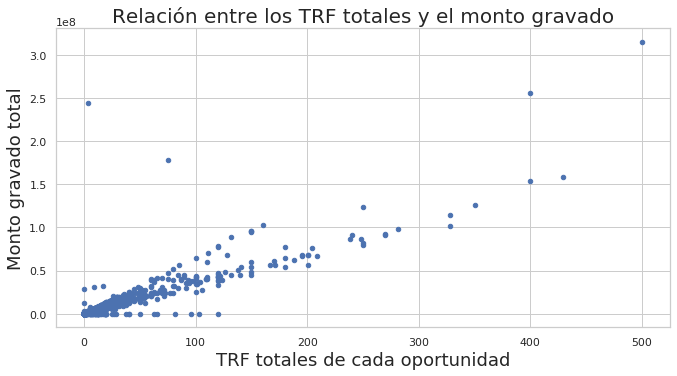

In [30]:
eciOp.plot(kind='scatter', x='TRF_totales', y='Total_Taxable_Amount_(converted)',figsize=(11,5.5))
g=plt.gca()
g.set_title("Relación entre los TRF totales y el monto gravado",\
            fontsize=20);
g.set_xlabel("TRF totales de cada oportunidad", fontsize=18);
g.set_ylabel("Monto gravado total", fontsize=18);

In [11]:
bubbleVendedores = eciWon.groupby(['Opportunity_Owner']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleVendedores.columns = ['Vendedor','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleVendedores['Monto Reescalado'] = bubbleVendedores['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleVendedores['Porcentaje de ganadas'] = (bubbleVendedores['Cantidad de ganadas']/bubbleVendedores['Total de Oportunidades'])*100
bubbleVendedores.head()

,Vendedor,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
0,Person_Name_0,0,1,"651,061.13",2,0.65,0.00
1,Person_Name_10,0,2,"32,912,058.32",1,32.91,0.00
2,Person_Name_11,26,71,"86,043,920.20",0,86.04,36.62
3,Person_Name_12,4,20,"873,557,641.15",0,873.56,20.00
4,Person_Name_13,434,756,"1,236,549,119.72",0,"1,236.55",57.41


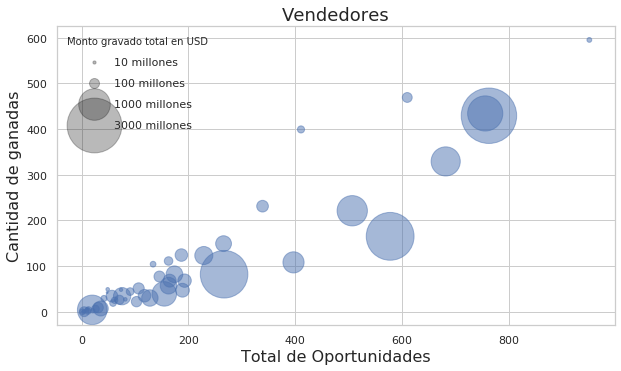

In [12]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleVendedores,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Vendedores", size=18)


for area in [10, 100, 1000, 3000]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

In [14]:
buro = eciWon.groupby(['Bureaucratic_Code']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
buro.columns = ['Codigo burocratico','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
buro['Monto Reescalado'] = buro['Monto gravado total'].apply(lambda x: x*0.00001)
buro['Porcentaje de ganadas'] = (buro['Cantidad de ganadas']/buro['Total de Oportunidades'])*100
#Sacamos los codigos que aparcen muy pocas veces para no caer en "la ecuacion mas peligrosa de la historia"
buro = buro[buro['Total de Oportunidades']>2]
buro

,Codigo burocratico,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
0,Bureaucratic_Code_0,11,11,"88,022,623.74",40,880.23,100.00
1,Bureaucratic_Code_1,58,177,"153,081,156.29",0,"1,530.81",32.77
2,Bureaucratic_Code_2,34,120,"576,405,272.08",1,"5,764.05",28.33
4,Bureaucratic_Code_4,4408,7400,"7,955,583,525.39",10,"79,555.84",59.57
5,Bureaucratic_Code_5,559,2080,"8,202,104,544.33",14,"82,021.05",26.88


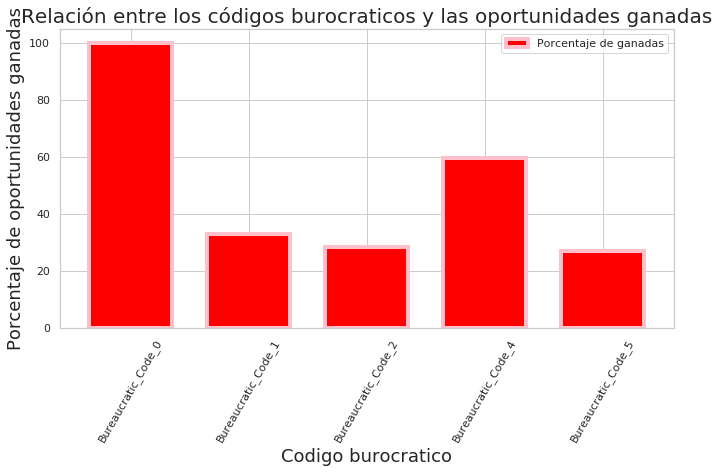

In [15]:
buro.plot(kind='bar', x='Codigo burocratico', y='Porcentaje de ganadas',\
                 width=0.7, figsize=(11,5.5), color='red',\
                 edgecolor="pink", linewidth=4,rot=60)
g=plt.gca()
g.set_title("Relación entre los códigos burocraticos y las oportunidades ganadas",\
            fontsize=20);
g.set_xlabel("Codigo burocratico", fontsize=18);
g.set_ylabel("Porcentaje de oportunidades ganadas", fontsize=18);

In [16]:
bubbleSource = eciWon.groupby(['Source ']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleSource.columns = ['Fuente de creacion de la oportunidad','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleSource['Monto Reescalado'] = bubbleSource['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleSource['Porcentaje de ganadas'] = (bubbleSource['Cantidad de ganadas']/bubbleSource['Total de Oportunidades'])*100
bubbleSource = bubbleSource[bubbleSource['Fuente de creacion de la oportunidad']!='None']
bubbleSource = bubbleSource[bubbleSource['Total de Oportunidades']>4]
bubbleSource

,Fuente de creacion de la oportunidad,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
2,Source_1,28,88,"302,422,601.18",2,302.42,31.82
3,Source_10,31,89,"98,600,853.83",1,98.60,34.83
4,Source_11,536,847,"1,250,039,359.75",14,"1,250.04",63.28
6,Source_13,374,533,"648,762,717.39",20,648.76,70.17
7,Source_2,26,68,"212,026,555.30",1,212.03,38.24
8,Source_3,159,302,"502,947,708.06",1,502.95,52.65
9,Source_4,16,32,"12,211,067.96",0,12.21,50.00
11,Source_6,5,17,"25,268,950.81",0,25.27,29.41
12,Source_7,908,2063,"4,921,689,697.21",0,"4,921.69",44.01
13,Source_9,486,871,"856,729,110.84",1,856.73,55.80


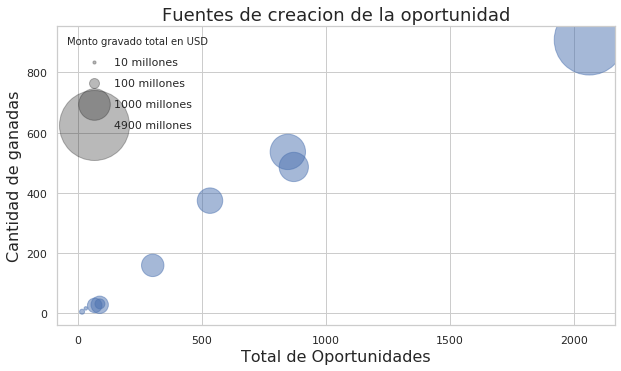

In [17]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleSource,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Fuentes de creacion de la oportunidad", size=18)


for area in [10, 100, 1000, 4900]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

In [18]:
bubbleAccount = eciWon.groupby(['Account_Name']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleAccount.columns = ['Cuentas de clientes','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleAccount['Monto Reescalado'] = bubbleAccount['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleAccount['Porcentaje de ganadas'] = (bubbleAccount['Cantidad de ganadas']/bubbleAccount['Total de Oportunidades'])*100
bubbleAccount = bubbleAccount[bubbleAccount['Total de Oportunidades']>35]
bubbleAccount.head()

,Cuentas de clientes,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
62,Account_Name_1067,47,94,"22,953,308.73",0,22.95,50.00
69,Account_Name_1075,67,83,"77,860,683.36",120,77.86,80.72
91,Account_Name_1100,23,45,"71,641,690.41",0,71.64,51.11
241,Account_Name_1274,61,77,"10,085,507.08",0,10.09,79.22
279,Account_Name_1313,49,68,"74,366,848.05",4,74.37,72.06


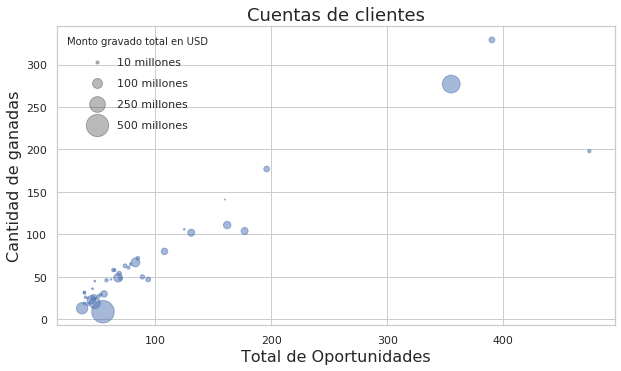

In [19]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleAccount,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Cuentas de clientes", size=18)


for area in [10, 100, 250, 500]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

In [20]:
bubbleAccountType = eciWon.groupby(['Account_Type']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleAccountType.columns = ['Tipo de cuenta cliente','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleAccountType['Monto Reescalado'] = bubbleAccountType['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleAccountType['Porcentaje de ganadas'] = (bubbleAccountType['Cantidad de ganadas']/bubbleAccountType['Total de Oportunidades'])*100
bubbleAccountType = bubbleAccountType[(bubbleAccountType['Total de Oportunidades']>17) & (bubbleAccountType['Tipo de cuenta cliente']!= 'None')]
bubbleAccountType

,Tipo de cuenta cliente,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
0,Account_Type_0,2332,3418,"1,460,419,236.69",0,"1,460.42",68.23
1,Account_Type_1,17,124,"1,171,374,915.52",1,"1,171.37",13.71
2,Account_Type_2,2282,4676,"7,330,780,267.19",10,"7,330.78",48.80
4,Account_Type_5,432,1445,"6,373,970,722.19",0,"6,373.97",29.90


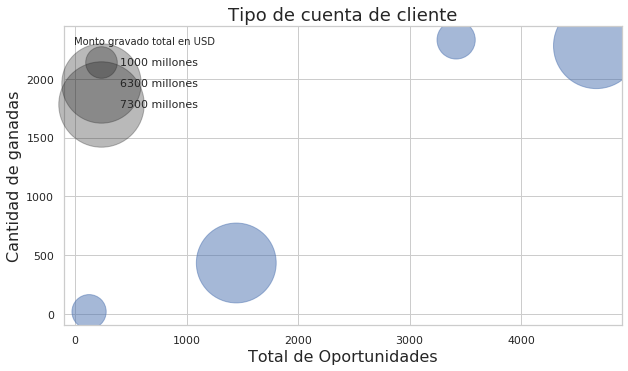

In [21]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleAccountType,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Tipo de cuenta de cliente", size=18)


for area in [1000, 6300, 7300]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

In [22]:
bubbleOpportunity = eciWon.groupby(['Opportunity_Type']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleOpportunity.columns = ['Tipo de oportunidad','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleOpportunity['Monto Reescalado'] = bubbleOpportunity['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleOpportunity['Porcentaje de ganadas'] = (bubbleOpportunity['Cantidad de ganadas']/bubbleOpportunity['Total de Oportunidades'])*100
bubbleOpportunity = bubbleOpportunity[bubbleOpportunity['Total de Oportunidades']>9]
bubbleOpportunity.head()

,Tipo de oportunidad,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
1,Opportunity_Type_1,2668,5128,"3,058,184,078.48",10,"3,058.18",52.03
2,Opportunity_Type_10,11,15,"2,239,493.39",0,2.24,73.33
4,Opportunity_Type_12,122,138,"34,133,962.40",0,34.13,88.41
6,Opportunity_Type_14,6,10,"720,554.95",0,0.72,60.00
10,Opportunity_Type_18,2,10,"38,703,671.00",68,38.70,20.00


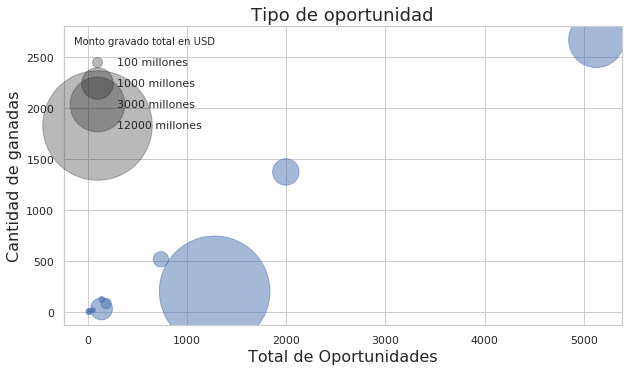

In [23]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleOpportunity,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Tipo de oportunidad", size=18)


for area in [100, 1000, 3000, 12000]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

In [24]:
bubbleDelivery = eciWon.groupby(['Delivery_Terms']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleDelivery.columns = ['Terminos de entrega','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleDelivery['Monto Reescalado'] = bubbleDelivery['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleDelivery['Porcentaje de ganadas'] = (bubbleDelivery['Cantidad de ganadas']/bubbleDelivery['Total de Oportunidades'])*100
bubbleDelivery = bubbleDelivery[bubbleDelivery['Total de Oportunidades']>4]
bubbleDelivery

,Terminos de entrega,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
1,Delivery_Terms_1,893,1985,"5,210,583,911.92",14,"5,210.58",44.99
2,Delivery_Terms_2,1544,3218,"3,568,384,870.32",10,"3,568.38",47.98
3,Delivery_Terms_3,15,32,"58,013,994.03",3,58.01,46.88
4,Delivery_Terms_4,1885,3446,"7,069,266,099.84",0,"7,069.27",54.70
5,Delivery_Terms_5,348,522,"287,827,441.05",0,287.83,66.67
6,Delivery_Terms_6,301,434,"460,816,376.45",0,460.82,69.35
7,Delivery_Terms_7,19,36,"212,346,194.54",0,212.35,52.78
8,Delivery_Terms_8,65,114,"117,079,070.04",0,117.08,57.02


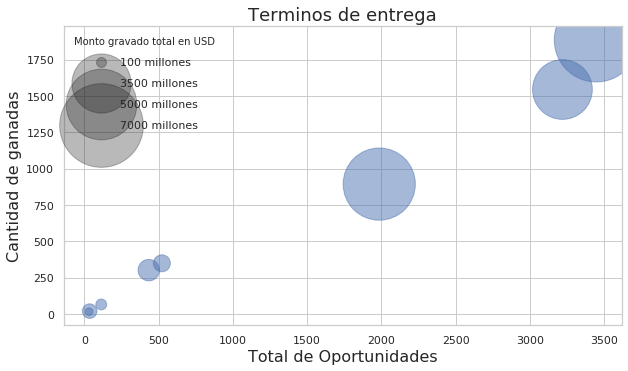

In [25]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleDelivery,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Terminos de entrega", size=18)


for area in [100, 3500, 5000, 7000]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

# Dudas para el grupo

¿Que es Quote_Type? 

Creo que es cuando cierran el trato legalmente. Cuando dice "Binding" me suena a que hay algún contrato o algo para cumplir, el precio imagino, non binding, me suena a que es más de palabra pero si alguno se arrepiente antes no hay que pagar etc. Después hay otra columna que tiene la fecha de expiración de este contrato, si se pasa imagino que ya pasa a ser non binding o que lo acordado ya no vale más.

In [116]:
eci['Quote_Type'].value_counts()

Non Binding    16777
Binding          170
Name: Quote_Type, dtype: int64